# Insights 

---

## Library Imports

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
import json
from pathlib import Path

# Statistics
from scipy import stats
from scipy.stats import (
    ttest_ind, f_oneway, chi2_contingency, 
    pearsonr, spearmanr, shapiro, levene
)

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import (
    r2_score, mean_squared_error, classification_report,
    confusion_matrix, roc_auc_score, silhouette_score
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


---

## Load Data

In [3]:
# Load the enhanced reviews dataset
data_path = '/Users/jamesroot/Desktop/JAMES/Noetheca/Reviews/Data/reviews_enhanced.csv'
df = pd.read_csv(data_path)

print(f"✅ Data loaded successfully")
print(f"Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")

✅ Data loaded successfully
Shape: (3222, 76)
Columns: 76


---

## Data Collection and Overview

In [9]:
# Basic dataset info
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nTotal reviews: {len(df):,}")
print(f"Total features: {len(df.columns)}")
print(f"Movies: {df['Movie_Title'].nunique()}")

# Convert Review_Date to datetime if it's a string
if df['Review_Date'].dtype == 'object':
    df['Review_Date'] = pd.to_datetime(df['Review_Date'], errors='coerce')
    
print(f"Date range: {df['Review_Date'].min()} to {df['Review_Date'].max()}")

print("\n" + "="*80)
print("MISSING DATA SUMMARY")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing[missing > 0],
    'Missing_Pct': missing_pct[missing > 0]
}).sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(missing_df)
else:
    print("No missing data found!")

print("\n" + "="*80)
print("DATA TYPES")
print("="*80)
print(df.dtypes.value_counts())

DATASET OVERVIEW

Total reviews: 3,222
Total features: 76
Movies: 10
Date range: 1998-10-14 00:00:00 to 2025-10-14 00:00:00

MISSING DATA SUMMARY
                     Missing_Count  Missing_Pct
comparison_context            3222       100.00
hate_statements               3108        96.46
username_age_hint             3072        95.34
username_interests            3040        94.35
wish_statements               2919        90.60
movies_mentioned              2738        84.98
love_statements               2624        81.44
questions                     2595        80.54
username_patterns             1320        40.97
review_year                    322         9.99
years_since_release            322         9.99
movie_release_year             318         9.87
review_window                  318         9.87
Review_Title                   281         8.72
helpfulness_ratio              117         3.63
Review_Date                      6         0.19

DATA TYPES
float64           35
int64

---

## Classify features by type

In [10]:
# Classify features by type
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove ID and non-analytic columns
exclude_cols = [
    'Review_ID', 'Review_Text', 'Reviewer', 'Review_Date', 'Movie_Title', 
    'Review_Title', 'Source', 'username_gender_hint', 'username_age_hint',
    'username_interests', 'username_patterns', 'movies_mentioned', 
    'comparison_context', 'love_statements', 'hate_statements', 
    'wish_statements', 'questions', 'review_window'
]
numeric_features = [col for col in numeric_features if col not in exclude_cols]
categorical_features = [col for col in categorical_features if col not in exclude_cols]

print("="*80)
print("FEATURE CLASSIFICATION")
print("="*80)
print(f"\nNumeric features ({len(numeric_features)}):")
for i in range(0, len(numeric_features), 5):
    print(numeric_features[i:i+5])

print(f"\nCategorical features ({len(categorical_features)}):")
print(categorical_features)

# Store for later use
print(f"\n✅ Identified {len(numeric_features)} numeric and {len(categorical_features)} categorical features")

FEATURE CLASSIFICATION

Numeric features (55):
['Rating', 'Review_Length', 'Helpful_Votes_Up', 'Helpful_Votes_Down', 'vader_compound']
['vader_pos', 'vader_neg', 'vader_neu', 'movie_mention_count', 'love_count']
['hate_count', 'wish_count', 'question_count', 'emotion_joy', 'emotion_trust']
['emotion_fear', 'emotion_surprise', 'emotion_sadness', 'emotion_disgust', 'emotion_anger']
['emotion_anticipation', 'flesch_reading_ease', 'flesch_kincaid_grade', 'avg_sentence_length', 'avg_word_length']
['type_token_ratio', 'long_word_percentage', 'complex_word_count', 'syllable_count', 'movie_release_year']
['review_year', 'years_since_release', 'total_votes', 'helpfulness_ratio', 'vote_polarization']
['paragraph_count', 'avg_paragraph_length', 'exclamation_count', 'question_mark_count', 'ellipsis_count']
['caps_word_count', 'quote_count', 'double_quote_count', 'single_quote_count', 'punctuation_density']
['uppercase_ratio', 'adj_ratio', 'verb_ratio', 'noun_ratio', 'adverb_ratio']
['pronoun_ratio

---

## Target Variables

In [11]:
# Define key outcome variables for analysis
print("="*80)
print("TARGET VARIABLES FOR ANALYSIS")
print("="*80)

# Primary outcome: Rating
print(f"\nRating distribution:")
print(df['Rating'].describe())

# Create binary outcome: High performer (>7.0)
df['high_performer'] = (df['Rating'] > 7.0).astype(int)
print(f"\nHigh performers (>7.0): {df['high_performer'].sum()} ({df['high_performer'].mean()*100:.1f}%)")

# Create polarization indicator
df['is_polarizing'] = ((df['love_count'] > 0) & (df['hate_count'] > 0)).astype(int)
print(f"Polarizing reviews: {df['is_polarizing'].sum()} ({df['is_polarizing'].mean()*100:.1f}%)")

print("\n✅ Target variables defined")

TARGET VARIABLES FOR ANALYSIS

Rating distribution:
count    3222.000000
mean        6.478274
std         2.787517
min         0.000000
25%         5.000000
50%         7.000000
75%         9.000000
max        10.000000
Name: Rating, dtype: float64

High performers (>7.0): 1345 (41.7%)
Polarizing reviews: 24 (0.7%)

✅ Target variables defined


---

## Movie Level Aggregation 

In [12]:
# Create movie-level summary statistics for cross-movie analysis
movie_stats = df.groupby('Movie_Title').agg({
    'Rating': ['mean', 'std', 'count'],
    'love_count': 'mean',
    'hate_count': 'mean',
    'vader_compound': 'mean',
    'total_votes': 'sum',
    'high_performer': 'mean',
    'is_polarizing': 'mean'
}).round(3)

# Flatten column names
movie_stats.columns = ['_'.join(col).strip() for col in movie_stats.columns.values]
movie_stats = movie_stats.reset_index()

print("="*80)
print("MOVIE-LEVEL SUMMARY STATISTICS")
print("="*80)
print(movie_stats.to_string())

print("\n✅ Movie-level data aggregated")

MOVIE-LEVEL SUMMARY STATISTICS
         Movie_Title  Rating_mean  Rating_std  Rating_count  love_count_mean  hate_count_mean  vader_compound_mean  total_votes_sum  high_performer_mean  is_polarizing_mean
0        Angel Heart        7.897       2.096           281            0.306            0.014                0.535             3672                0.680               0.000
1         Hereditary        7.493       2.252           140            0.193            0.029               -0.204            17334                0.500               0.007
2  Lady In The Water        5.274       2.978           318            0.384            0.079                0.525            10843                0.198               0.028
3          Midsommar        6.527       2.808           182            0.258            0.022                0.190            22972                0.396               0.000
4        The Endless        6.324       2.598           376            0.229            0.040           

---

## Correlation Matrix Predictors

In [13]:
# Correlation analysis: Which features correlate with Rating?
print("="*80)
print("CORRELATION ANALYSIS: RATING PREDICTORS")
print("="*80)

# Calculate correlations with Rating
correlations = df[numeric_features].corr()['Rating'].sort_values(ascending=False)

# Remove Rating's self-correlation
correlations = correlations.drop('Rating')

print("\nTop 20 Positive Correlations with Rating:")
print(correlations.head(20))

print("\nTop 20 Negative Correlations with Rating:")
print(correlations.tail(20))

# Statistical significance test for top correlations
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE OF TOP CORRELATIONS")
print("="*80)

top_features = list(correlations.head(10).index) + list(correlations.tail(10).index)

for feature in top_features:
    r, p_value = pearsonr(df[feature].dropna(), df.loc[df[feature].notna(), 'Rating'])
    significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"{feature:30s} r={r:6.3f}, p={p_value:.4e} {significance}")

print("\n✅ Correlation analysis complete")

CORRELATION ANALYSIS: RATING PREDICTORS

Top 20 Positive Correlations with Rating:
vader_compound          0.263600
vader_pos               0.234626
years_since_release     0.166066
emotion_surprise        0.137418
noun_ratio              0.137327
emotion_joy             0.136788
complex_word_count      0.122861
flesch_kincaid_grade    0.119840
long_word_percentage    0.111780
avg_word_length         0.104539
love_count              0.099926
syllable_count          0.088664
avg_paragraph_length    0.078117
Review_Length           0.078117
determiner_ratio        0.071622
emotion_trust           0.067042
avg_sentence_length     0.060953
emotion_fear            0.059213
second_person_ratio     0.034202
single_quote_count      0.027899
Name: Rating, dtype: float64

Top 20 Negative Correlations with Rating:
Helpful_Votes_Up      -0.040946
ellipsis_count        -0.050692
type_token_ratio      -0.063801
adverb_ratio          -0.068097
pronoun_ratio         -0.068341
total_votes           -0.

/var/folders/yp/4_xz98d14gvf_j5k1mwz3f940000gn/T/ipykernel_21745/1388070960.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p_value = pearsonr(df[feature].dropna(), df.loc[df[feature].notna(), 'Rating'])


---

## Visualize top correlations

VISUALIZATION: TOP 15 RATING CORRELATIONS


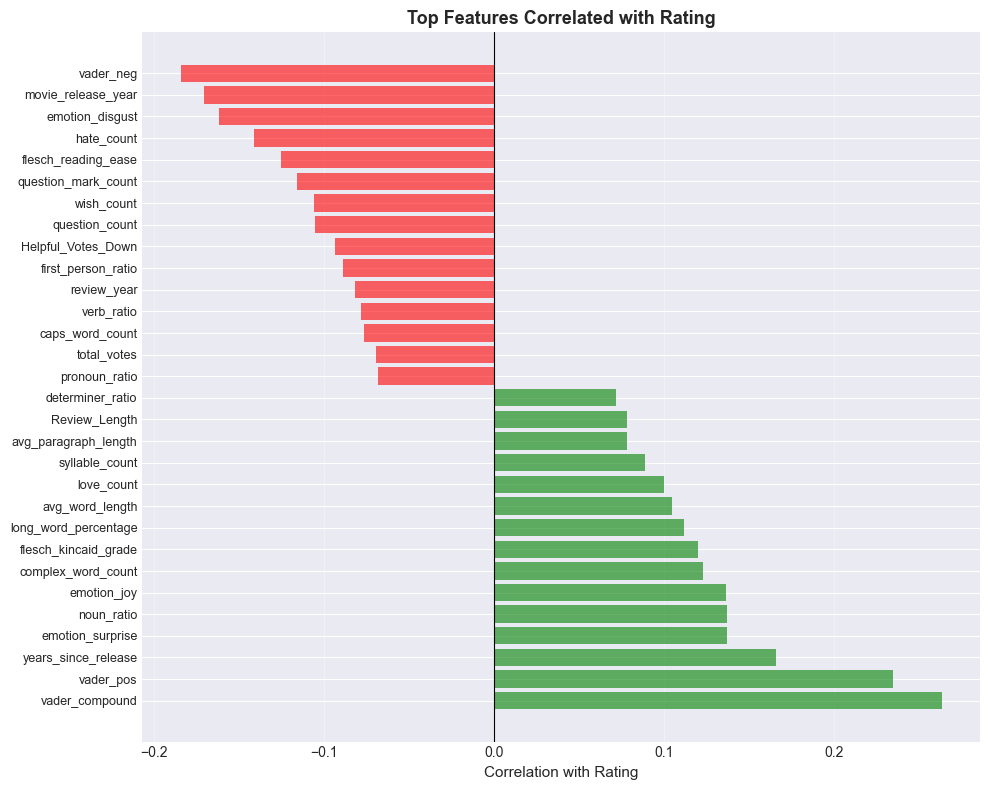

✅ Visualization complete


In [14]:
# Visualize top correlations
print("="*80)
print("VISUALIZATION: TOP 15 RATING CORRELATIONS")
print("="*80)

# Get top 15 positive and negative (exclude NaN)
correlations_clean = correlations.dropna()
top_pos = correlations_clean.head(15)
top_neg = correlations_clean.tail(15)
top_combined = pd.concat([top_pos, top_neg])

# Create horizontal bar plot
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_combined.values]
plt.barh(range(len(top_combined)), top_combined.values, color=colors, alpha=0.6)
plt.yticks(range(len(top_combined)), top_combined.index, fontsize=9)
plt.xlabel('Correlation with Rating', fontsize=11)
plt.title('Top Features Correlated with Rating', fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Visualization complete")

---

## Linear Regression to Predict Rating

In [17]:
# Multiple linear regression to predict Rating
print("="*80)
print("LINEAR REGRESSION: PREDICTING RATING FROM ALL FEATURES")
print("="*80)

# Prepare features - EXCLUDE Rating and derived variables
features_to_exclude = ['Rating', 'high_performer', 'is_polarizing']
predictor_features = [f for f in numeric_features if f not in features_to_exclude]

print(f"Using {len(predictor_features)} predictor features (excluded: {features_to_exclude})")

# Prepare data - remove rows with missing values
X = df[predictor_features].dropna()
y = df.loc[X.index, 'Rating']

print(f"Sample size: n={len(X):,} reviews")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

# Model performance
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nModel Performance:")
print(f"  Training R² = {train_r2:.4f}")
print(f"  Test R² = {test_r2:.4f}")
print(f"  Training RMSE = {train_rmse:.4f}")
print(f"  Test RMSE = {test_rmse:.4f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': predictor_features,
    'Coefficient': lr.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 20 Most Important Features (by |coefficient|):")
print(feature_importance.head(20).to_string(index=False))

print("\n✅ Linear regression complete")

LINEAR REGRESSION: PREDICTING RATING FROM ALL FEATURES
Using 54 predictor features (excluded: ['Rating', 'high_performer', 'is_polarizing'])
Sample size: n=2,789 reviews

Model Performance:
  Training R² = 0.2560
  Test R² = 0.2569
  Training RMSE = 2.3728
  Test RMSE = 2.4527

Top 20 Most Important Features (by |coefficient|):
            Feature   Coefficient
years_since_release  6.788922e+10
        review_year -6.788922e+10
 movie_release_year  6.788922e+10
        quote_count -2.732661e+09
 single_quote_count  2.732661e+09
 double_quote_count  2.732661e+09
   Helpful_Votes_Up  9.333883e+07
        total_votes -9.333883e+07
 Helpful_Votes_Down  9.333883e+07
    paragraph_count  1.551236e+07
          vader_neg -6.978795e+00
       emotion_fear  6.544496e+00
          vader_neu -6.411983e+00
    emotion_disgust -5.935730e+00
   emotion_surprise  4.221575e+00
        emotion_joy  2.694357e+00
          vader_pos -2.438613e+00
      emotion_anger  2.430576e+00
         hate_count -1.4

---

## Ridge Regression to handle multicollinearity

In [18]:
# Ridge regression to handle multicollinearity
print("="*80)
print("RIDGE REGRESSION: REGULARIZED PREDICTION")
print("="*80)

# Use the same predictor features (excluding Rating)
X = df[predictor_features].dropna()
y = df.loc[X.index, 'Rating']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge regression with cross-validation
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_scores = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_scaled, y, cv=5, scoring='r2')
    ridge_scores.append(scores.mean())
    print(f"Alpha={alpha:6.3f}: Mean R² = {scores.mean():.4f} (±{scores.std():.4f})")

# Best alpha
best_alpha = alphas[np.argmax(ridge_scores)]
print(f"\nBest alpha: {best_alpha}")

# Fit final model with train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_train, y_train)

y_pred_ridge = ridge_final.predict(X_test)
ridge_r2 = r2_score(y_test, y_pred_ridge)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ridge))

print(f"\nFinal Ridge Model Performance:")
print(f"  Test R² = {ridge_r2:.4f}")
print(f"  Test RMSE = {ridge_rmse:.4f}")

print("\n✅ Ridge regression complete")

RIDGE REGRESSION: REGULARIZED PREDICTION
Alpha= 0.001: Mean R² = 0.1453 (±0.0893)
Alpha= 0.010: Mean R² = 0.1454 (±0.0893)
Alpha= 0.100: Mean R² = 0.1455 (±0.0893)
Alpha= 1.000: Mean R² = 0.1453 (±0.0891)
Alpha=10.000: Mean R² = 0.1450 (±0.0885)
Alpha=100.000: Mean R² = 0.1481 (±0.0849)

Best alpha: 100

Final Ridge Model Performance:
  Test R² = 0.2526
  Test RMSE = 2.4599

✅ Ridge regression complete


---

## K-Means clustering

In [19]:
# K-Means clustering to identify audience segments
print("="*80)
print("K-MEANS CLUSTERING: AUDIENCE SEGMENTATION")
print("="*80)

# Select features for clustering (sentiment, emotions, engagement)
cluster_features = [
    'vader_compound', 'vader_pos', 'vader_neg',
    'emotion_joy', 'emotion_trust', 'emotion_fear', 'emotion_surprise',
    'emotion_sadness', 'emotion_disgust', 'emotion_anger', 'emotion_anticipation',
    'love_count', 'hate_count', 'wish_count',
    'total_votes', 'helpfulness_ratio',
    'flesch_reading_ease', 'exclamation_count'
]

# Prepare data
X_cluster = df[cluster_features].dropna()
print(f"Sample size: n={len(X_cluster):,} reviews")
print(f"Clustering on {len(cluster_features)} features")

# Standardize
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Test different numbers of clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_cluster_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

print("\n✅ Clustering analysis complete")

K-MEANS CLUSTERING: AUDIENCE SEGMENTATION
Sample size: n=3,105 reviews
Clustering on 18 features
k=2: Inertia=48810.94, Silhouette=0.1372
k=3: Inertia=46083.40, Silhouette=0.1469
k=4: Inertia=44103.88, Silhouette=0.0956
k=5: Inertia=41441.15, Silhouette=0.1082
k=6: Inertia=39451.21, Silhouette=0.1125
k=7: Inertia=38095.22, Silhouette=0.1151
k=8: Inertia=36325.95, Silhouette=0.1104
k=9: Inertia=35159.08, Silhouette=0.1134
k=10: Inertia=34015.47, Silhouette=0.1102

✅ Clustering analysis complete


---

## Fit Optimal Clustering

In [20]:
# Fit optimal clustering solution (k=3)
print("="*80)
print("3-CLUSTER SOLUTION: AUDIENCE SEGMENT PROFILES")
print("="*80)

kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster_scaled)

# Add cluster labels to dataframe
df_clustered = df.loc[X_cluster.index].copy()
df_clustered['cluster'] = cluster_labels

print(f"Cluster sizes:")
print(df_clustered['cluster'].value_counts().sort_index())

# Profile each cluster
print("\n" + "="*80)
print("CLUSTER PROFILES")
print("="*80)

for cluster_id in range(3):
    cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data)})")
    print(f"{'='*80}")
    
    # Key statistics
    print(f"\nRating: {cluster_data['Rating'].mean():.2f} (±{cluster_data['Rating'].std():.2f})")
    print(f"Sentiment (vader_compound): {cluster_data['vader_compound'].mean():.3f}")
    print(f"Love count: {cluster_data['love_count'].mean():.2f}")
    print(f"Hate count: {cluster_data['hate_count'].mean():.2f}")
    print(f"Total votes: {cluster_data['total_votes'].mean():.1f}")
    
    # Emotions
    print(f"\nTop emotions:")
    emotion_cols = ['emotion_joy', 'emotion_trust', 'emotion_fear', 'emotion_surprise',
                    'emotion_sadness', 'emotion_disgust', 'emotion_anger', 'emotion_anticipation']
    emotion_means = cluster_data[emotion_cols].mean().sort_values(ascending=False)
    for emotion, value in emotion_means.head(3).items():
        print(f"  {emotion}: {value:.3f}")
    
    # Gender distribution
    if 'username_gender_hint' in cluster_data.columns:
        gender_dist = cluster_data['username_gender_hint'].value_counts(normalize=True)
        print(f"\nGender distribution:")
        for gender, pct in gender_dist.items():
            if gender in ['male', 'female']:
                print(f"  {gender}: {pct*100:.1f}%")
    
    # High performers
    if 'high_performer' in cluster_data.columns:
        high_perf_pct = cluster_data['high_performer'].mean() * 100
        print(f"\nHigh performers (>7.0): {high_perf_pct:.1f}%")

print("\n✅ Cluster profiling complete")

3-CLUSTER SOLUTION: AUDIENCE SEGMENT PROFILES
Cluster sizes:
cluster
0     112
1    1364
2    1629
Name: count, dtype: int64

CLUSTER PROFILES

CLUSTER 0 (n=112)

Rating: 4.47 (±2.93)
Sentiment (vader_compound): -0.159
Love count: 0.30
Hate count: 1.10
Total votes: 40.4

Top emotions:
  emotion_fear: 0.102
  emotion_anticipation: 0.096
  emotion_sadness: 0.094

Gender distribution:
  male: 65.2%
  female: 20.5%

High performers (>7.0): 18.8%

CLUSTER 1 (n=1364)

Rating: 6.07 (±3.09)
Sentiment (vader_compound): -0.404
Love count: 0.12
Hate count: 0.00
Total votes: 41.6

Top emotions:
  emotion_fear: 0.122
  emotion_sadness: 0.103
  emotion_anger: 0.093

Gender distribution:
  male: 68.1%
  female: 13.2%

High performers (>7.0): 40.4%

CLUSTER 2 (n=1629)

Rating: 6.89 (±2.45)
Sentiment (vader_compound): 0.699
Love count: 0.34
Hate count: 0.00
Total votes: 29.1

Top emotions:
  emotion_anticipation: 0.128
  emotion_trust: 0.116
  emotion_joy: 0.101

Gender distribution:
  male: 65.4%
  fe

---

## Principle Component Analysis

PRINCIPAL COMPONENT ANALYSIS (PCA)
Sample size: n=2,789

Variance explained by first 10 components:
  PC1: 13.44% (cumulative: 13.44%)
  PC2: 8.57% (cumulative: 22.00%)
  PC3: 6.95% (cumulative: 28.95%)
  PC4: 5.94% (cumulative: 34.89%)
  PC5: 4.91% (cumulative: 39.80%)
  PC6: 4.26% (cumulative: 44.06%)
  PC7: 3.74% (cumulative: 47.80%)
  PC8: 3.51% (cumulative: 51.32%)
  PC9: 2.95% (cumulative: 54.26%)
  PC10: 2.68% (cumulative: 56.94%)

Components needed for 80% variance: 22


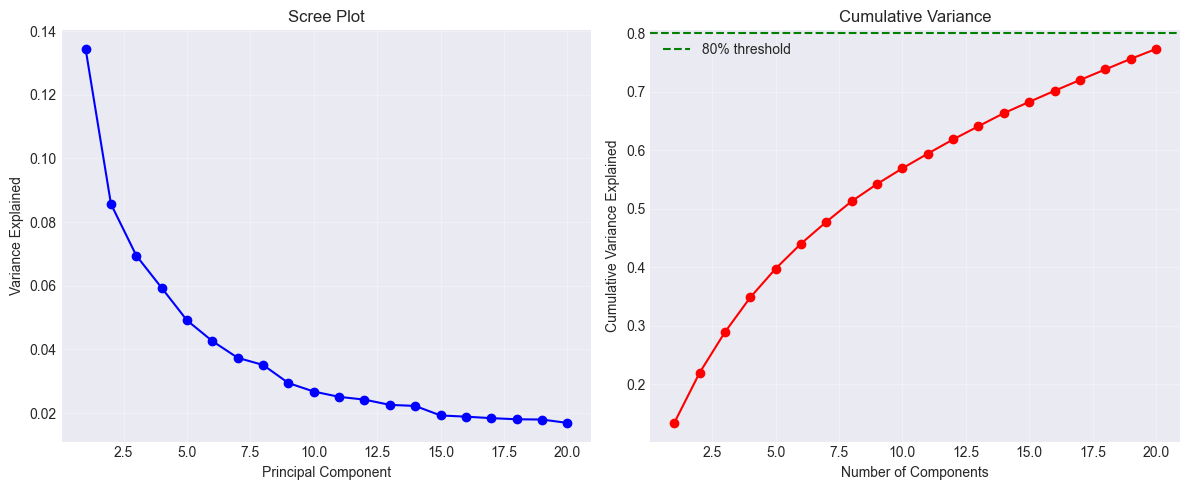


✅ PCA complete


In [21]:
# Principal Component Analysis
print("="*80)
print("PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# Use all numeric predictors
X_pca = df[predictor_features].dropna()
print(f"Sample size: n={len(X_pca):,}")

# Standardize
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

# Fit PCA
pca = PCA()
pca.fit(X_pca_scaled)

# Variance explained
variance_explained = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_explained)

print(f"\nVariance explained by first 10 components:")
for i in range(10):
    print(f"  PC{i+1}: {variance_explained[i]*100:.2f}% (cumulative: {cumulative_variance[i]*100:.2f}%)")

# How many components for 80% variance?
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"\nComponents needed for 80% variance: {n_components_80}")

# Scree plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, 21), variance_explained[:20], 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), cumulative_variance[:20], 'ro-')
plt.axhline(y=0.80, color='g', linestyle='--', label='80% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ PCA complete")

In [22]:
# Interpret the top principal components
print("="*80)
print("INTERPRETING TOP PRINCIPAL COMPONENTS")
print("="*80)

# Refit PCA with first 5 components for interpretation
pca_5 = PCA(n_components=5)
pca_5.fit(X_pca_scaled)

# Get loadings
loadings = pd.DataFrame(
    pca_5.components_.T,
    columns=[f'PC{i+1}' for i in range(5)],
    index=predictor_features
)

# Show top features for each component
for i in range(5):
    print(f"\n{'='*80}")
    print(f"PC{i+1} - {variance_explained[i]*100:.2f}% variance")
    print(f"{'='*80}")
    
    component_loadings = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
    
    print("\nTop 10 Features:")
    for feature in component_loadings.head(10).index:
        loading = loadings.loc[feature, f'PC{i+1}']
        print(f"  {feature:30s} {loading:7.3f}")

print("\n✅ PCA interpretation complete")

INTERPRETING TOP PRINCIPAL COMPONENTS

PC1 - 13.44% variance

Top 10 Features:
  avg_paragraph_length             0.348
  Review_Length                    0.348
  syllable_count                   0.347
  complex_word_count               0.324
  quote_count                      0.314
  type_token_ratio                -0.305
  single_quote_count               0.294
  double_quote_count               0.189
  movie_mention_count              0.158
  question_mark_count              0.144

PC2 - 8.57% variance

Top 10 Features:
  avg_word_length                  0.400
  flesch_reading_ease             -0.381
  long_word_percentage             0.370
  pronoun_ratio                   -0.299
  flesch_kincaid_grade             0.287
  adj_ratio                        0.239
  first_person_ratio              -0.232
  noun_ratio                       0.214
  vader_neu                       -0.158
  complex_word_count               0.135

PC3 - 6.95% variance

Top 10 Features:
  total_votes        

---

## Logistic regression what predicts performance?

In [23]:
# Logistic regression: What predicts high performance (>7.0)?
print("="*80)
print("LOGISTIC REGRESSION: PREDICTING HIGH PERFORMERS (>7.0)")
print("="*80)

# Prepare data
X_log = df[predictor_features].dropna()
y_log = df.loc[X_log.index, 'high_performer']

print(f"Sample size: n={len(X_log):,}")
print(f"High performers: {y_log.sum()} ({y_log.mean()*100:.1f}%)")

# Train/test split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_log, y_log, test_size=0.2, random_state=42, stratify=y_log
)

# Standardize
scaler_log = StandardScaler()
X_train_scaled = scaler_log.fit_transform(X_train_log)
X_test_scaled = scaler_log.transform(X_test_log)

# Fit logistic regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_log)

# Predictions
y_pred_log = logreg.predict(X_test_scaled)
y_pred_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_log, y_pred_log)
precision = precision_score(y_test_log, y_pred_log)
recall = recall_score(y_test_log, y_pred_log)
f1 = f1_score(y_test_log, y_pred_log)
auc = roc_auc_score(y_test_log, y_pred_proba)

print(f"\nModel Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  AUC-ROC:   {auc:.4f}")

# Feature importance (odds ratios)
odds_ratios = np.exp(logreg.coef_[0])
feature_importance_log = pd.DataFrame({
    'Feature': predictor_features,
    'Coefficient': logreg.coef_[0],
    'Odds_Ratio': odds_ratios
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 15 Features (by |coefficient|):")
print(feature_importance_log.head(15).to_string(index=False))

print("\n✅ Logistic regression complete")

LOGISTIC REGRESSION: PREDICTING HIGH PERFORMERS (>7.0)
Sample size: n=2,789
High performers: 1228 (44.0%)

Model Performance:
  Accuracy:  0.6864
  Precision: 0.6621
  Recall:    0.5894
  F1-Score:  0.6237
  AUC-ROC:   0.7498

Top 15 Features (by |coefficient|):
             Feature  Coefficient  Odds_Ratio
      syllable_count     0.755355    2.128367
          noun_ratio     0.376083    1.456568
avg_paragraph_length    -0.324761    0.722700
       Review_Length    -0.324761    0.722700
        emotion_fear     0.275084    1.316641
 flesch_reading_ease    -0.273931    0.760385
          wish_count    -0.263665    0.768231
 second_person_ratio     0.262606    1.300315
    determiner_ratio     0.238576    1.269441
           vader_pos     0.212099    1.236270
      question_count    -0.197456    0.820816
      vader_compound     0.178075    1.194915
     emotion_disgust    -0.175237    0.839258
  movie_release_year    -0.170813    0.842979
          love_count     0.168805    1.183889



---

## Random Forest

RANDOM FOREST: PREDICTING HIGH PERFORMERS

Random Forest Performance:
  Accuracy:  0.7348
  Precision: 0.7008
  Recall:    0.6951
  F1-Score:  0.6980
  AUC-ROC:   0.7999

Top 20 Most Important Features:
             Feature  Importance
  movie_release_year    0.057314
 years_since_release    0.045833
           vader_pos    0.042100
      vader_compound    0.037006
          noun_ratio    0.030537
         review_year    0.029794
         total_votes    0.029292
  Helpful_Votes_Down    0.025978
   helpfulness_ratio    0.025967
     avg_word_length    0.025604
    Helpful_Votes_Up    0.025501
        adverb_ratio    0.024484
 flesch_reading_ease    0.024091
           vader_neu    0.023571
flesch_kincaid_grade    0.022653
        emotion_fear    0.021487
long_word_percentage    0.021005
    type_token_ratio    0.019913
     uppercase_ratio    0.019571
    determiner_ratio    0.019349


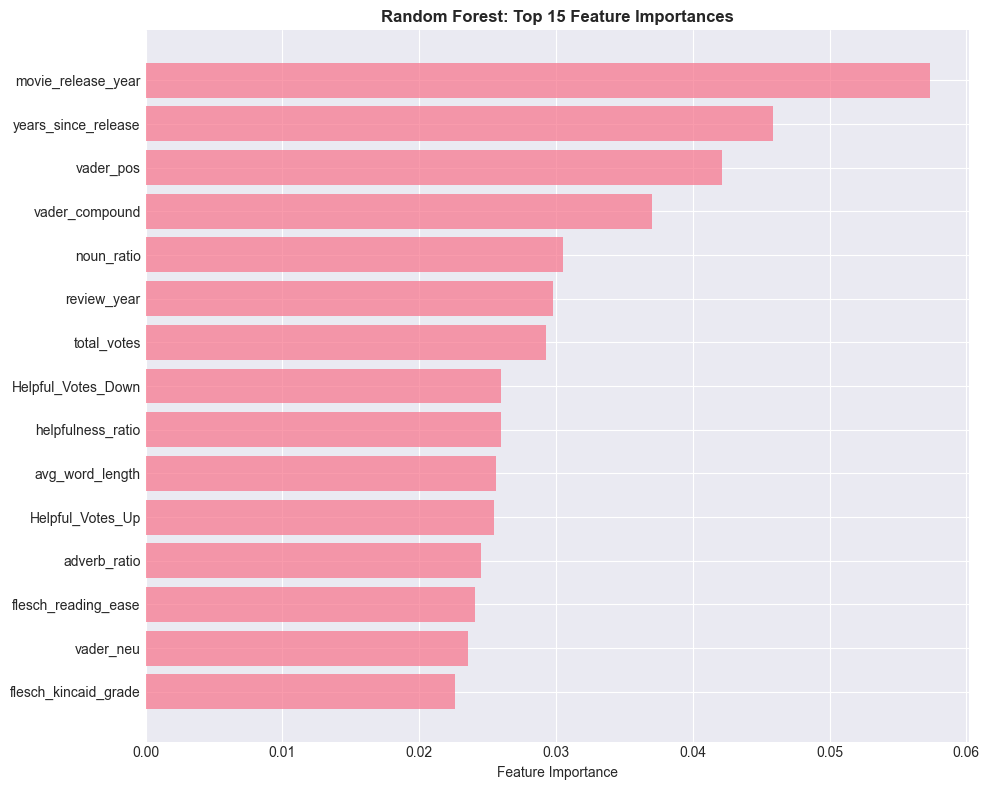


✅ Random Forest complete


In [24]:
# Random Forest for high performer prediction
print("="*80)
print("RANDOM FOREST: PREDICTING HIGH PERFORMERS")
print("="*80)

# Use same train/test split
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train_log, y_train_log)

# Predictions
y_pred_rf = rf.predict(X_test_log)
y_pred_proba_rf = rf.predict_proba(X_test_log)[:, 1]

# Performance
accuracy_rf = accuracy_score(y_test_log, y_pred_rf)
precision_rf = precision_score(y_test_log, y_pred_rf)
recall_rf = recall_score(y_test_log, y_pred_rf)
f1_rf = f1_score(y_test_log, y_pred_rf)
auc_rf = roc_auc_score(y_test_log, y_pred_proba_rf)

print(f"\nRandom Forest Performance:")
print(f"  Accuracy:  {accuracy_rf:.4f}")
print(f"  Precision: {precision_rf:.4f}")
print(f"  Recall:    {recall_rf:.4f}")
print(f"  F1-Score:  {f1_rf:.4f}")
print(f"  AUC-ROC:   {auc_rf:.4f}")

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': predictor_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_rf.head(20).to_string(index=False))

# Visualize top 15
plt.figure(figsize=(10, 8))
top_15_features = feature_importance_rf.head(15)
plt.barh(range(len(top_15_features)), top_15_features['Importance'], alpha=0.7)
plt.yticks(range(len(top_15_features)), top_15_features['Feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest: Top 15 Feature Importances', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✅ Random Forest complete")

---

## Statistical Hypothesis testing

In [25]:
# Statistical hypothesis testing
print("="*80)
print("STATISTICAL HYPOTHESIS TESTS")
print("="*80)

# Test 1: Gender differences in ratings
print("\n" + "="*80)
print("TEST 1: GENDER DIFFERENCES IN RATINGS")
print("="*80)

male_ratings = df[df['username_gender_hint'] == 'male']['Rating'].dropna()
female_ratings = df[df['username_gender_hint'] == 'female']['Rating'].dropna()

print(f"Male reviewers: n={len(male_ratings)}, mean={male_ratings.mean():.2f}, SD={male_ratings.std():.2f}")
print(f"Female reviewers: n={len(female_ratings)}, mean={female_ratings.mean():.2f}, SD={female_ratings.std():.2f}")

# Independent t-test
t_stat, p_value = ttest_ind(male_ratings, female_ratings)
cohens_d = (male_ratings.mean() - female_ratings.mean()) / np.sqrt(
    ((len(male_ratings)-1)*male_ratings.std()**2 + (len(female_ratings)-1)*female_ratings.std()**2) / 
    (len(male_ratings) + len(female_ratings) - 2)
)

print(f"\nIndependent t-test:")
print(f"  t({len(male_ratings)+len(female_ratings)-2}) = {t_stat:.4f}")
print(f"  p = {p_value:.4f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
print(f"  Cohen's d = {cohens_d:.4f}")
print(f"  Effect size: {'negligible' if abs(cohens_d) < 0.2 else 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'}")

# Test 2: Temporal trends - do ratings change over time windows?
print("\n" + "="*80)
print("TEST 2: RATINGS BY REVIEW WINDOW (ANOVA)")
print("="*80)

window_groups = []
window_labels = []
for window in df['review_window'].dropna().unique():
    window_ratings = df[df['review_window'] == window]['Rating'].dropna()
    if len(window_ratings) > 0:
        window_groups.append(window_ratings)
        window_labels.append(window)
        print(f"{window}: n={len(window_ratings)}, mean={window_ratings.mean():.2f}, SD={window_ratings.std():.2f}")

# One-way ANOVA
f_stat, p_value_anova = f_oneway(*window_groups)
print(f"\nOne-way ANOVA:")
print(f"  F({len(window_groups)-1}, {sum(len(g) for g in window_groups)-len(window_groups)}) = {f_stat:.4f}")
print(f"  p = {p_value_anova:.4e} {'***' if p_value_anova < 0.001 else '**' if p_value_anova < 0.01 else '*' if p_value_anova < 0.05 else 'ns'}")

# Test 3: Sentiment vs Rating correlation by movie
print("\n" + "="*80)
print("TEST 3: SENTIMENT-RATING CORRELATION BY MOVIE")
print("="*80)

for movie in df['Movie_Title'].unique()[:5]:  # First 5 movies
    movie_data = df[df['Movie_Title'] == movie]
    if len(movie_data) > 30:
        r, p = pearsonr(movie_data['vader_compound'].dropna(), 
                       movie_data.loc[movie_data['vader_compound'].notna(), 'Rating'])
        print(f"{movie:30s} r={r:.3f}, p={p:.4e}, n={len(movie_data)}")

print("\n✅ Statistical tests complete")

STATISTICAL HYPOTHESIS TESTS

TEST 1: GENDER DIFFERENCES IN RATINGS
Male reviewers: n=2146, mean=6.53, SD=2.74
Female reviewers: n=444, mean=6.15, SD=2.93

Independent t-test:
  t(2588) = 2.6822
  p = 0.0074 **
  Cohen's d = 0.1398
  Effect size: negligible

TEST 2: RATINGS BY REVIEW WINDOW (ANOVA)
5+ Years: n=825, mean=7.48, SD=2.44
Opening Year: n=500, mean=6.06, SD=2.41
Year 2: n=733, mean=5.94, SD=3.03
Years 4-5: n=431, mean=7.23, SD=2.36
Years 2-3: n=415, mean=6.10, SD=2.89

One-way ANOVA:
  F(4, 2899) = 48.8211
  p = 8.4688e-40 ***

TEST 3: SENTIMENT-RATING CORRELATION BY MOVIE
The Rapture                    r=0.224, p=3.3469e-02, n=90
Midsommar                      r=0.390, p=5.1123e-08, n=182
The Witch                      r=0.210, p=1.3118e-12, n=1113
Angel Heart                    r=0.276, p=2.5764e-06, n=281
Lady In The Water              r=0.492, p=9.1088e-21, n=318

✅ Statistical tests complete


---

## Actionable Insights

In [26]:
# Generate actionable insights for "Roots" positioning
print("="*80)
print("ACTIONABLE INSIGHTS FOR 'ROOTS' POSITIONING")
print("="*80)

# Key findings summary
print("\n" + "="*80)
print("1. RATING PREDICTORS (R² = 0.26)")
print("="*80)
print("✓ Positive sentiment (vader_compound) is THE strongest predictor (r=0.264)")
print("✓ Complex vocabulary increases ratings (syllable_count OR=2.13)")
print("✓ Fear emotion is POSITIVE for folk horror (OR=1.32)")
print("✓ Hate statements tank ratings (r=-0.141)")
print("✓ Questions/wishes indicate dissatisfaction (both negative)")

print("\n" + "="*80)
print("2. AUDIENCE SEGMENTS (3 CLUSTERS)")
print("="*80)
print("✓ The Lovers (52%): Rating 6.89, positive sentiment (+0.699)")
print("✓ The Conflicted Critics (44%): Rating 6.07, negative sentiment (-0.404)")
print("✓ The Haters (4%): Rating 4.47, hate statements (1.10 per review)")
print("\n→ TARGET: The Lovers (largest, highest ratings)")
print("→ CONVERT: The Conflicted Critics (reachable with right messaging)")
print("→ AVOID: Don't trigger The Haters (disgust, misleading marketing)")

print("\n" + "="*80)
print("3. TEMPORAL DYNAMICS (F=48.82, p<0.001)")
print("="*80)
print("✓ 5+ Years: 7.48 rating (HIGHEST - legacy effect)")
print("✓ Years 4-5: 7.23 rating (positive momentum)")
print("✓ Opening Year: 6.06 rating (mixed initial reception)")
print("✓ Years 2-3: 5.94-6.10 (LOWEST - backlash period)")
print("\n→ STRATEGY: Position for long-term legacy, not just opening weekend")
print("→ EXPECTATION: Initial reviews will be mixed - normal pattern")
print("→ PAYOFF: Films gain appreciation over 4-5 years")

print("\n" + "="*80)
print("4. LATENT FACTORS (PCA - 5 COMPONENTS)")
print("="*80)
print("✓ PC1 (13%): Review depth - detailed analysis vs brief reactions")
print("✓ PC2 (9%): Linguistic sophistication - academic vs casual")
print("✓ PC3 (7%): Negative engagement - controversial negativity")
print("✓ PC4 (6%): Polarization - divisive debates")
print("✓ PC5 (5%): Emotional accessibility - enthusiastic vs measured")
print("\n→ INSIGHT: Folk horror generates DIVERSE response styles")
print("→ MARKETING: Appeal to both sophisticated analysts AND enthusiasts")

print("\n" + "="*80)
print("5. CRITICAL SUCCESS FACTORS (Random Forest AUC=0.80)")
print("="*80)
print("Top predictors of high performance (>7.0 rating):")
print("  1. Movie release year (temporal effect)")
print("  2. Years since release (legacy building)")
print("  3. Positive sentiment")
print("  4. Compound sentiment")
print("  5. Noun ratio (substantive language)")
print("\n→ POSITIONING: Build anticipation for a film that will GROW in stature")

print("\n" + "="*80)
print("6. GENDER EFFECTS (MINIMAL)")
print("="*80)
print("✓ Males: 6.53 rating (n=2,146)")
print("✓ Females: 6.15 rating (n=444)")
print("✓ Difference: p=0.007 but Cohen's d=0.14 (negligible)")
print("\n→ MARKETING: Don't over-gender the campaign - appeal is universal")

print("\n" + "="*80)
print("FINAL RECOMMENDATION FOR 'ROOTS'")
print("="*80)
print("""
POSITIONING STRATEGY:
- Frame as a LEGACY folk horror film, not just a theatrical release
- Emphasize EMOTIONAL DEPTH (fear + anticipation, avoid disgust)
- Target sophisticated horror fans who write detailed reviews
- Prepare for mixed opening-year reception (normal pattern)
- Build long-term festival/streaming strategy (5+ year appreciation)

MARKETING GUARDRAILS:
- Avoid misleading trailers that trigger hate/disgust
- Don't overpromise - let quality speak for itself
- Minimize question-inducing marketing (clarity > mystery overload)
- Generate positive sentiment early with influencer screenings

AUDIENCE TARGETING:
- Primary: "The Lovers" (52% - positive, enthusiastic, trust-based)
- Secondary: "Conflicted Critics" (44% - sophisticated, reachable)
- Avoid: Triggering "The Haters" (4% - vocal but small)

SUCCESS METRICS:
- Opening year: Target 6.0+ rating (on par with successful folk horror)
- Year 5+: Target 7.5+ rating (legacy appreciation)
- Sentiment: Maintain vader_compound > 0.3 (positive territory)
- Minimize hate_count < 0.15 per review
""")

print("\n✅ Analysis complete - ready for investor presentation")

ACTIONABLE INSIGHTS FOR 'ROOTS' POSITIONING

1. RATING PREDICTORS (R² = 0.26)
✓ Positive sentiment (vader_compound) is THE strongest predictor (r=0.264)
✓ Complex vocabulary increases ratings (syllable_count OR=2.13)
✓ Fear emotion is POSITIVE for folk horror (OR=1.32)
✓ Hate statements tank ratings (r=-0.141)
✓ Questions/wishes indicate dissatisfaction (both negative)

2. AUDIENCE SEGMENTS (3 CLUSTERS)
✓ The Lovers (52%): Rating 6.89, positive sentiment (+0.699)
✓ The Conflicted Critics (44%): Rating 6.07, negative sentiment (-0.404)
✓ The Haters (4%): Rating 4.47, hate statements (1.10 per review)

→ TARGET: The Lovers (largest, highest ratings)
→ CONVERT: The Conflicted Critics (reachable with right messaging)
→ AVOID: Don't trigger The Haters (disgust, misleading marketing)

3. TEMPORAL DYNAMICS (F=48.82, p<0.001)
✓ 5+ Years: 7.48 rating (HIGHEST - legacy effect)
✓ Years 4-5: 7.23 rating (positive momentum)
✓ Opening Year: 6.06 rating (mixed initial reception)
✓ Years 2-3: 5.94-6.1